In [30]:
import numpy as np
import matplotlib.pyplot as plt


In [31]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

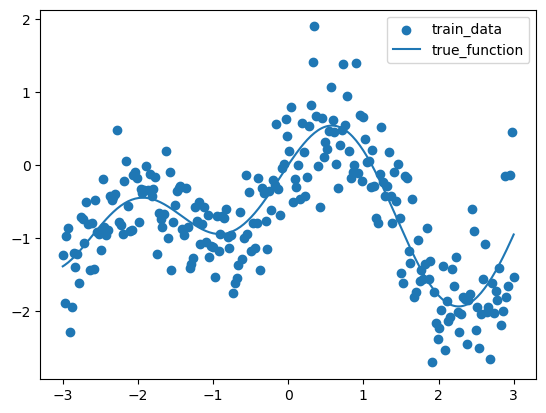

In [32]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [33]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [34]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [35]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0/alpha + np.sum((X_new @ posterior_cov) * X_new, axis=1)
std_pred = np.sqrt(var_pred)

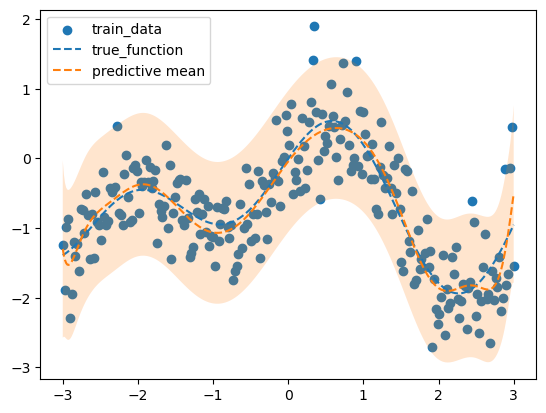

In [36]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [37]:
def log_evidence(lamb, X, y, alpha):

    X = np.asarray(X); y = np.asarray(y)
    N, M = X.shape

    A = lamb * np.eye(M) + alpha * (X.T @ X)

    try:
        L = np.linalg.cholesky(A)
        logdetA = 2.0 * np.sum(np.log(np.diag(L)))
        A_inv = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(M)))
    except np.linalg.LinAlgError:
        sign, logdetA = np.linalg.slogdet(A)
        if sign <= 0:
            return -np.inf
        A_inv = np.linalg.inv(A)

    m_N = alpha * (A_inv @ X.T @ y)

    resid = y - X @ m_N
    data_fit = alpha * resid @ resid
    w_pen    = lamb  * m_N @ m_N

    logev = 0.5 * (M*np.log(lamb) + N*np.log(alpha) - logdetA
                   - data_fit - w_pen - N*np.log(2*np.pi))
    return float(logev)


In [38]:
lamb_grid = np.logspace(-6, 3, 200)
logevs = np.array([log_evidence(l, X, y, alpha) for l in lamb_grid])
lambda_star = float(lamb_grid[np.argmax(logevs)])
lambda_star



13.987131026472387

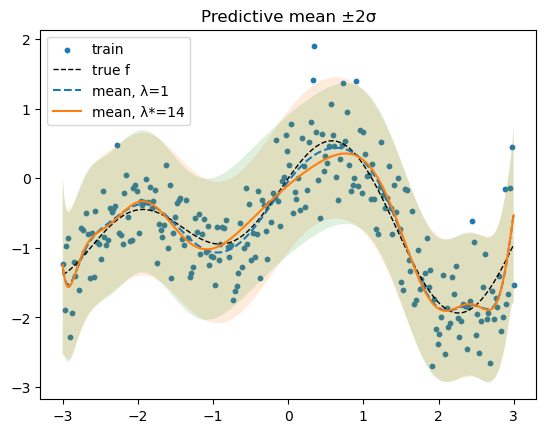

In [39]:

def posterior_mean_cov(lamb, X, y, alpha):
    M = X.shape[1]
    A = lamb * np.eye(M) + alpha * (X.T @ X)
    L = np.linalg.cholesky(A)
    A_inv = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(M)))
    m_N = alpha * (A_inv @ X.T @ y)
    return m_N, A_inv

def predictive_mean_var(m_N, S_N, X_new, alpha):
    mean = X_new @ m_N
    var  = 1.0/alpha + np.sum((X_new @ S_N) * X_new, axis=1)
    return mean, var

x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

m_base, S_base = posterior_mean_cov(lamb=1.0, X=X, y=y, alpha=alpha)
m_star, S_star = posterior_mean_cov(lamb=lambda_star, X=X, y=y, alpha=alpha)

mean_b, var_b = predictive_mean_var(m_base, S_base, X_new, alpha)
mean_s, var_s = predictive_mean_var(m_star, S_star, X_new, alpha)

plt.scatter(x, y, s=10, label="train")
plt.plot(x_new, f_true(x_new), 'k--', lw=1, label="true f")
plt.plot(x_new, mean_b,  ls='--', label="mean, λ=1")
plt.fill_between(x_new, mean_b-2*np.sqrt(var_b), mean_b+2*np.sqrt(var_b), alpha=0.15)
plt.plot(x_new, mean_s,  ls='-',  label=f"mean, λ*={lambda_star:.3g}")
plt.fill_between(x_new, mean_s-2*np.sqrt(var_s), mean_s+2*np.sqrt(var_s), alpha=0.15)
plt.legend(); plt.title("Predictive mean ±2σ")
plt.show()

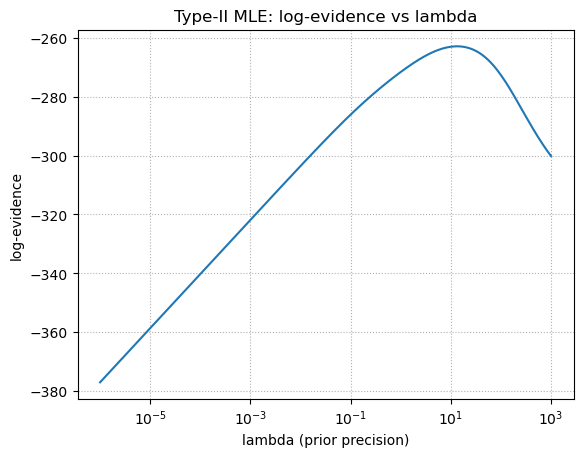

In [40]:
plt.semilogx(lamb_grid, logevs)
plt.xlabel("lambda (prior precision)"); plt.ylabel("log-evidence")
plt.title("Type-II MLE: log-evidence vs lambda"); plt.grid(True, which="both", ls=":")
plt.show()

In [41]:
def rmse(a, b): return float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2)))
rmse_true_base = rmse(mean_b, f_true(x_new))
rmse_true_star = rmse(mean_s, f_true(x_new))
print(f"RMSE(true): λ=1 → {rmse_true_base:.4f} | λ* → {rmse_true_star:.4f}")


RMSE(true): λ=1 → 0.1066 | λ* → 0.1358
